# Tutorial 08

## fitting tests foregrounds

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`HL likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 20
APOSCALE = 6.
PSBIN = 60
LMIN = 30
LMAX = 210
FWHM = [np.deg2rad(52.8/60.),np.deg2rad(19./60.),np.deg2rad(11./60.),np.deg2rad(4.94/60.)]
KWARGS = {'nlive':1000}

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float64,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP,3,map23f.shape[1]),dtype=np.float64)
for i in range(NSAMP):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

# WARNNING: reducing magnitude for better SNR
vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float64,verbose=0)/100
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float64,verbose=0)/100
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float64,verbose=0)/100
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float64,verbose=0)/100

nmap23 = np.random.normal(0.,1.,size=(NSAMP,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

- T mode, templated dust

iter: 4093 | +1000 | bound: 1 | nc: 1 | ncall: 36005 | eff(%): 14.145 | loglstar:   -inf < -0.623 <    inf | logz: -4.320 +/-  0.036 | dlogz:  0.001 >  1.009                                         

G $\chi^2_{min}$ 2.0063775762092653
HL $\chi^2_{min}$ 1.2455704476101281
CPU times: user 5min 10s, sys: 1min 5s, total: 6min 16s
Wall time: 1min 40s


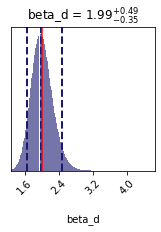

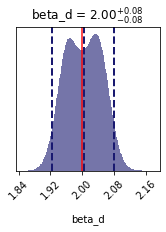

In [2]:
%%time

datamap = {95:map95,150:map150,353:map353}
datanoise = {95:nmap95,150:nmap150,353:nmap353}
databeam = {95:FWHM[1],150:FWHM[2],353:FWHM[3]}

fidmap = {95:mapcmb,150:mapcmb,353:mapcmb}

tmpmap = {353:map353}
tmpnoise = {353:nmap353}
tmpbeam = {353:FWHM[3]}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                templates=tmpmap,template_beams=tmpbeam,template_noises=tmpnoise,
                targets='T',foreground='tdust',background='acmb')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#-------------------------------------------- replace mock
f = pp._foreground_obj
f.reset({'beta_d':2.})
pp._foreground_obj = f
pp.data_bp = f.bandpower() + pp.noise_bp[0] + np.mean(pp.fiducial_bp,axis=0)
#--------------------------------------------

pp.likelihood='gauss'
result_g = pp.analyse(kwargs=KWARGS)

pp.likelihood='hl'
result_h = pp.analyse(kwargs=KWARGS)

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[2.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[2.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

- EB mode, templated dust

iter: 13285 | +1000 | bound: 20 | nc: 1 | ncall: 63924 | eff(%): 22.347 | loglstar:   -inf < -1.925 <    inf | logz: -15.207 +/-  0.174 | dlogz:  0.001 >  1.009                                      

G $\chi^2_{min}$ 12.27400380168066
HL $\chi^2_{min}$ 3.8508701741031146
CPU times: user 1h 29min 33s, sys: 4min 1s, total: 1h 33min 35s
Wall time: 15min 22s


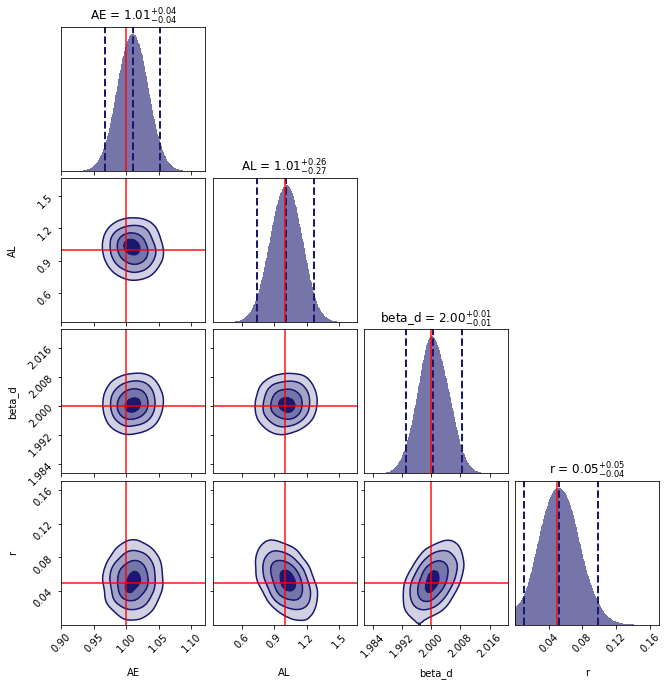

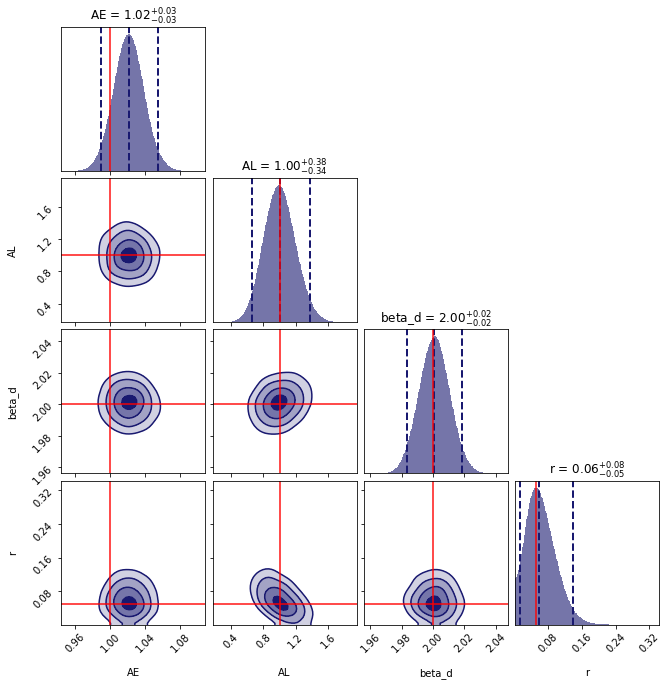

In [3]:
%%time

datamap = {95:map95,150:map150,353:map353}
datanoise = {95:nmap95,150:nmap150,353:nmap353}
databeam = {95:FWHM[1],150:FWHM[2],353:FWHM[3]}

fidmap = {95:mapcmb,150:mapcmb,353:mapcmb}

tmpmap = {353:map353}
tmpnoise = {353:nmap353}
tmpbeam = {353:FWHM[3]}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                templates=tmpmap,template_beams=tmpbeam,template_noises=tmpnoise,
                targets='EB',foreground='tdust',background='acmb')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#-------------------------------------------- replace mock
f = pp._foreground_obj
f.reset({'beta_d':2.})
pp._foreground_obj = f
pp.data_bp = f.bandpower() + pp.noise_bp[0] + np.mean(pp.fiducial_bp,axis=0)
#--------------------------------------------

pp.likelihood='gauss'
result_g = pp.analyse(kwargs=KWARGS)

pp.likelihood='hl'
result_h = pp.analyse(kwargs=KWARGS)

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,2.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,2.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

- EB mode, sync+dust

iter: 15479 | +1000 | bound: 32 | nc: 1 | ncall: 83478 | eff(%): 19.741 | loglstar:   -inf < -2.380 <    inf | logz: -17.939 +/-  0.194 | dlogz:  0.001 >  1.009                                      

G $\chi^2_{min}$ 12.76820860434561
HL $\chi^2_{min}$ 4.760450408319876
CPU times: user 3h 48min 9s, sys: 1h 19min 2s, total: 5h 7min 11s
Wall time: 38min 50s


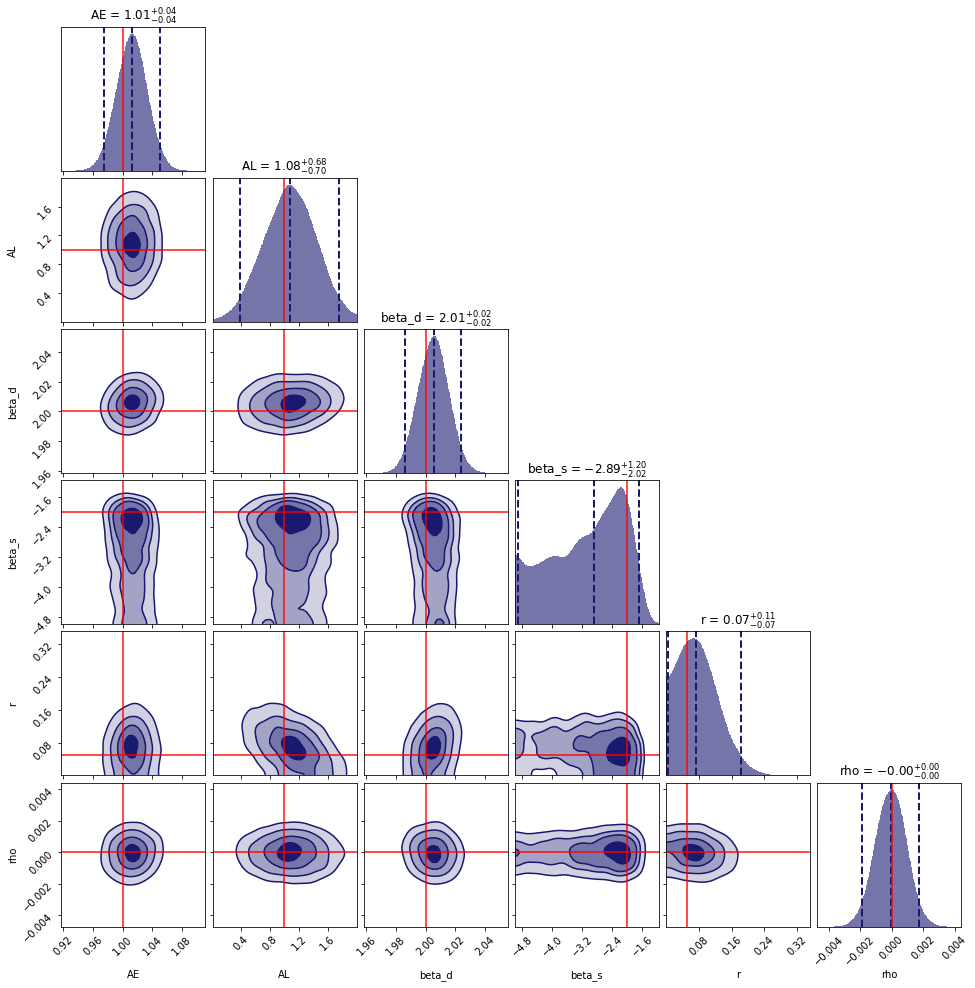

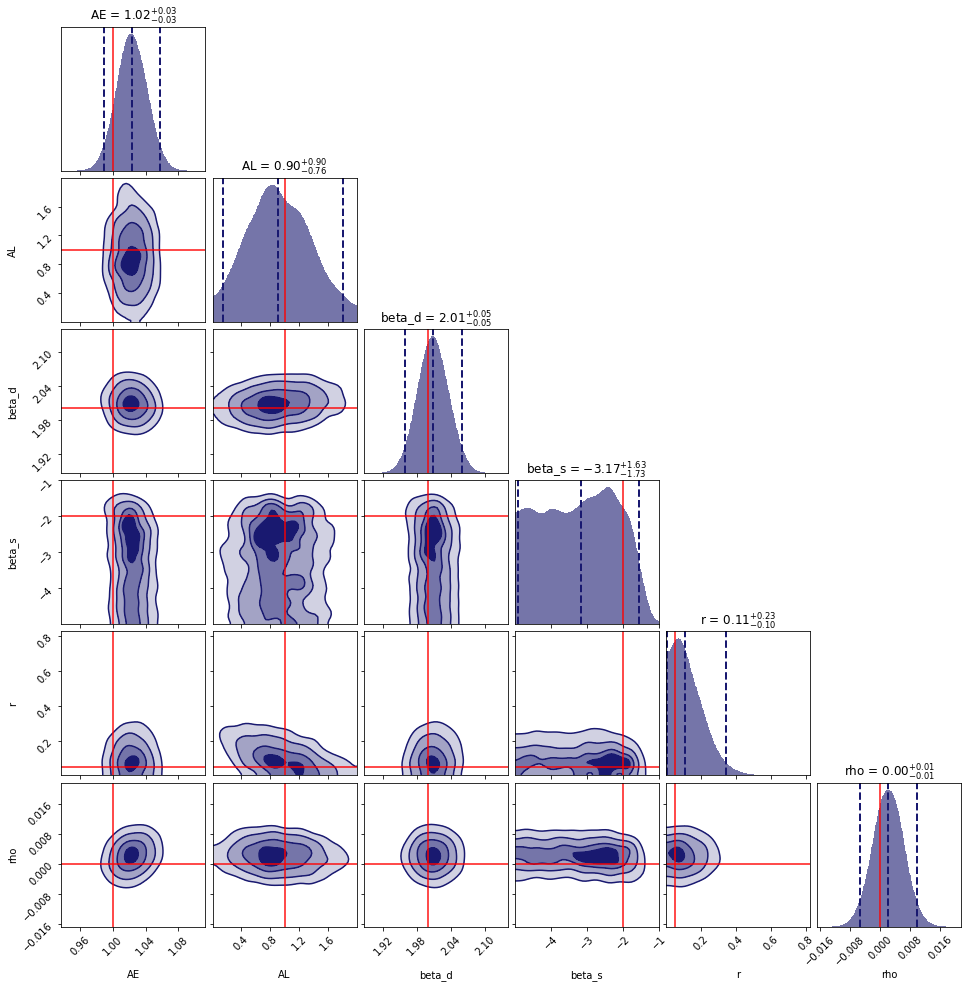

In [4]:
%%time

datamap = {23:map23,95:map95,150:map150,353:map353}
datanoise = {23:nmap23,95:nmap95,150:nmap150,353:nmap353}
databeam = {23:FWHM[0],95:FWHM[1],150:FWHM[2],353:FWHM[3]}

fidmap = {23:mapcmb,95:mapcmb,150:mapcmb,353:mapcmb}

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                templates=tmpmap,template_beams=tmpbeam,template_noises=tmpnoise,
                targets='EB',foreground='tsynctdust',background='acmb')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#-------------------------------------------- replace mock
f = pp._foreground_obj
f.reset({'beta_d':2.,'beta_s':-2,'rho':0.})
pp._foreground_obj = f
pp.data_bp = f.bandpower() + pp.noise_bp[0] + np.mean(pp.fiducial_bp,axis=0)
#--------------------------------------------

pp.likelihood='gauss'
result_g = pp.analyse(kwargs=KWARGS)

pp.likelihood='hl'
result_h = pp.analyse(kwargs=KWARGS)

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],
                           truths=[1.,1.,2.,-2.,0.05,0.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],
                           truths=[1.,1.,2.,-2.,0.05,0.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

- B mode, sync+dust

iter: 10585 | +1000 | bound: 16 | nc: 1 | ncall: 58661 | eff(%): 19.749 | loglstar:   -inf < -0.888 <    inf | logz: -11.465 +/-  0.156 | dlogz:  0.001 >  1.009                                      

G $\chi^2_{min}$ 5.305707600584995
HL $\chi^2_{min}$ 1.7768057728253406
CPU times: user 1h 41min 2s, sys: 4min 8s, total: 1h 45min 11s
Wall time: 15min 33s


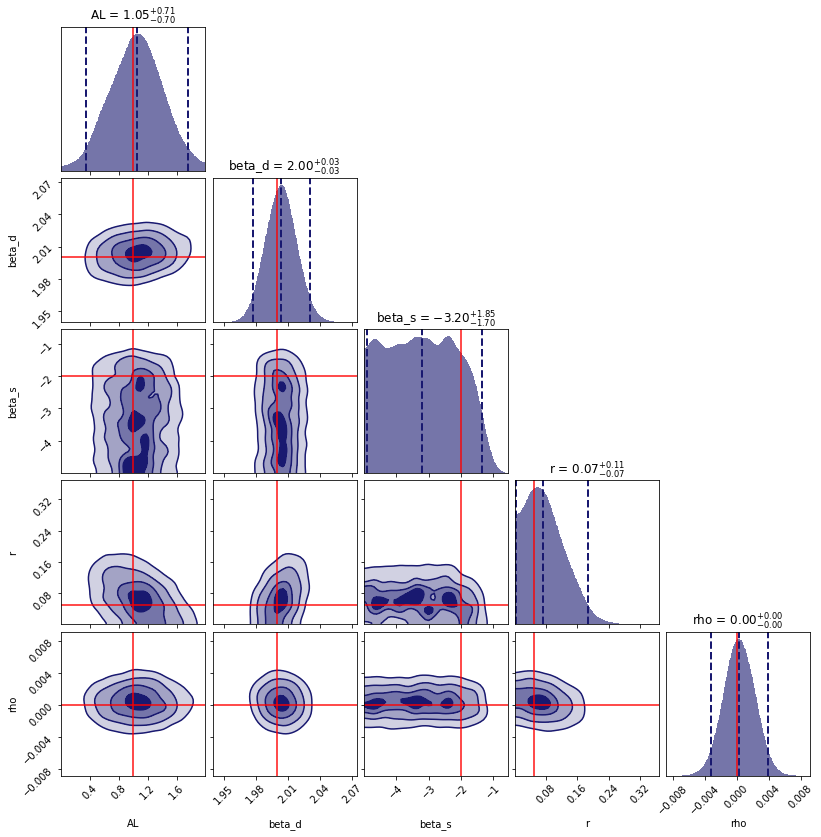

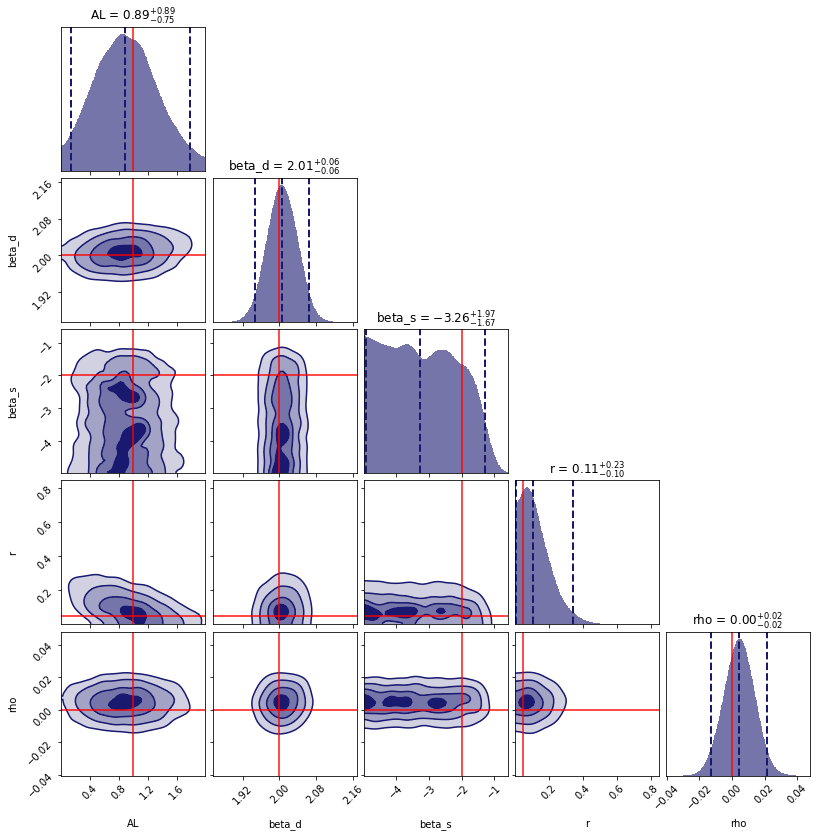

In [5]:
%%time

datamap = {23:map23,95:map95,150:map150,353:map353}
datanoise = {23:nmap23,95:nmap95,150:nmap150,353:nmap353}
databeam = {23:FWHM[0],95:FWHM[1],150:FWHM[2],353:FWHM[3]}

fidmap = {23:mapcmb,95:mapcmb,150:mapcmb,353:mapcmb}

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                templates=tmpmap,template_beams=tmpbeam,template_noises=tmpnoise,
                targets='B',foreground='tsynctdust',background='acmb')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

#-------------------------------------------- replace mock
f = pp._foreground_obj
f.reset({'beta_d':2.,'beta_s':-2,'rho':0.})
pp._foreground_obj = f
pp.data_bp = f.bandpower() + pp.noise_bp[0] + np.mean(pp.fiducial_bp,axis=0)
#--------------------------------------------

pp.likelihood='gauss'
result_g = pp.analyse(kwargs=KWARGS)

pp.likelihood='hl'
result_h = pp.analyse(kwargs=KWARGS)

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],
                           truths=[1.,2.,-2.,0.05,0.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],
                           truths=[1.,2.,-2.,0.05,0.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

end